In [ ]:

import torch
import torch.nn as nn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import r2_score



## Main


In [ ]:

## df = pd.DataFrame(np.random.randn(1300, 35))

df = pd.read_csv('datesBrokenUp_MovingAVG_FINAL_DATA_rcalix.csv')
df


In [ ]:

df = df.drop(["Unnamed: 0", "Date_Map"], axis=1)
df


In [ ]:

df = simulate_sine_dataset(df)
df



## This


/Users/user/opt/anaconda3/envs/py37_Transfer_Learning/lib/python3.7/site-packages/ipykernel_launcher.py:80: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


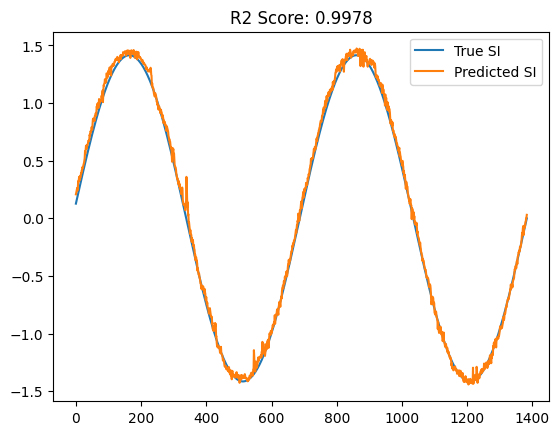

In [4]:

import torch
import torch.nn as nn
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score
from torch.utils.data import DataLoader, Dataset
from sklearn.preprocessing import StandardScaler

# === Sine overwrite function ===
def overwrite_with_sine(df):
    N = len(df)
    t = np.linspace(0, 4 * np.pi, N)
    sine = np.sin(t)
    df.iloc[:, 2] = sine  # SI
    df.iloc[:, 5] = np.roll(sine, 1)
    df.iloc[:, 8] = 2 * sine
    df.iloc[:, 10] = np.cos(t)
    return df

# === Sequence dataset ===
class SequenceDataset(Dataset):
    def __init__(self, data, seq_len):
        self.seq_len = seq_len
        self.x = []
        self.y = []
        for i in range(len(data) - seq_len):
            self.x.append(data[i:i+seq_len])
            self.y.append(data[i+seq_len, 2])  # Target = SI
        self.x = torch.tensor(np.stack(self.x), dtype=torch.float32)
        self.y = torch.tensor(self.y, dtype=torch.float32)

    def __len__(self):
        return len(self.x)
    def __getitem__(self, idx):
        return self.x[idx], self.y[idx]

# === Transformer model ===
class TinyGPT(nn.Module):
    def __init__(self, input_dim, emb_dim, seq_len, nhead=1, nlayers=1):
        super().__init__()
        self.in_proj = nn.Linear(input_dim, emb_dim)
        self.pos_emb = nn.Parameter(torch.randn(1, seq_len, emb_dim))
        encoder_layer = nn.TransformerEncoderLayer(d_model=emb_dim, nhead=nhead, batch_first=True)
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=nlayers)
        self.out_proj = nn.Linear(emb_dim, 1)

    def forward(self, x):
        x = self.in_proj(x) + self.pos_emb
        x = self.transformer(x)
        return self.out_proj(x[:, -1]).squeeze(-1)

# === Main function ===
def train_and_plot(csv_path):
    df = pd.read_csv(csv_path)
    df = df.select_dtypes(include=[np.number]).dropna(axis=1)
    df = overwrite_with_sine(df)

    scaler = StandardScaler()
    scaled = scaler.fit_transform(df.values)

    seq_len = 10
    ds = SequenceDataset(scaled, seq_len)
    loader = DataLoader(ds, batch_size=64, shuffle=True)

    model = TinyGPT(input_dim=scaled.shape[1], emb_dim=32, seq_len=seq_len)
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
    loss_fn = nn.MSELoss()

    for epoch in range(20):
        for xb, yb in loader:
            pred = model(xb)
            loss = loss_fn(pred, yb)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

    model.eval()
    with torch.no_grad():
        all_x = torch.tensor(ds.x, dtype=torch.float32)
        all_y = ds.y
        preds = model(all_x)

    r2 = r2_score(all_y.numpy(), preds.numpy())
    plt.plot(all_y.numpy(), label="True SI")
    plt.plot(preds.numpy(), label="Predicted SI")
    plt.title(f"R2 Score: {r2:.4f}")
    plt.legend()
    plt.show()

# Example usage:
train_and_plot("datesBrokenUp_MovingAVG_FINAL_DATA_rcalix.csv")

